# Regression after Unsmoothing

This notebook would use Li2CO3 data from investing.com (which totally have data from 2018 to 2023) and the unit is CNY/TON. 

In [9]:
import warnings 
warnings.filterwarnings('ignore')
from utils.utils import transform_data, plot_correlogram, get_stock_data
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa

In [3]:
li2co3 = transform_data("../data/Lithium Carbonate 99%Min China Spot Historical Data.csv")

         Date       Price        Open        High         Low  Vol. Change %
0  10/27/2023  155,500.00  155,500.00  158,000.00  153,000.00   NaN   -1.27%
1  10/26/2023  157,500.00  157,500.00  160,000.00  155,000.00   NaN   -1.25%
2  10/25/2023  159,500.00  159,500.00  162,000.00  157,000.00   NaN    1.27%
3  10/24/2023  157,500.00  157,500.00  160,000.00  155,000.00   NaN   -0.63%
4  10/23/2023  158,500.00  158,500.00  161,000.00  156,000.00   NaN   -2.46%


Please enter the column names, separated by a comma:  Date, Price, 1, 2, 3, 4, 5


<AxesSubplot: xlabel='Date'>

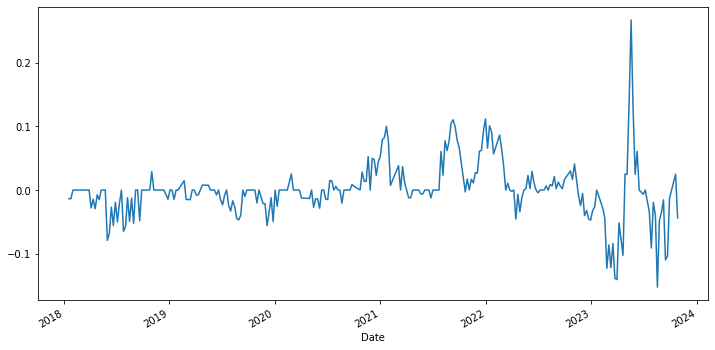

In [4]:
# Specify the size of the figure
plt.figure(figsize=(12, 6))
li2co3.Log_Return.plot()

In [5]:
# ro is observed data
ro = li2co3[li2co3.index > '2018-05-26'].Log_Return

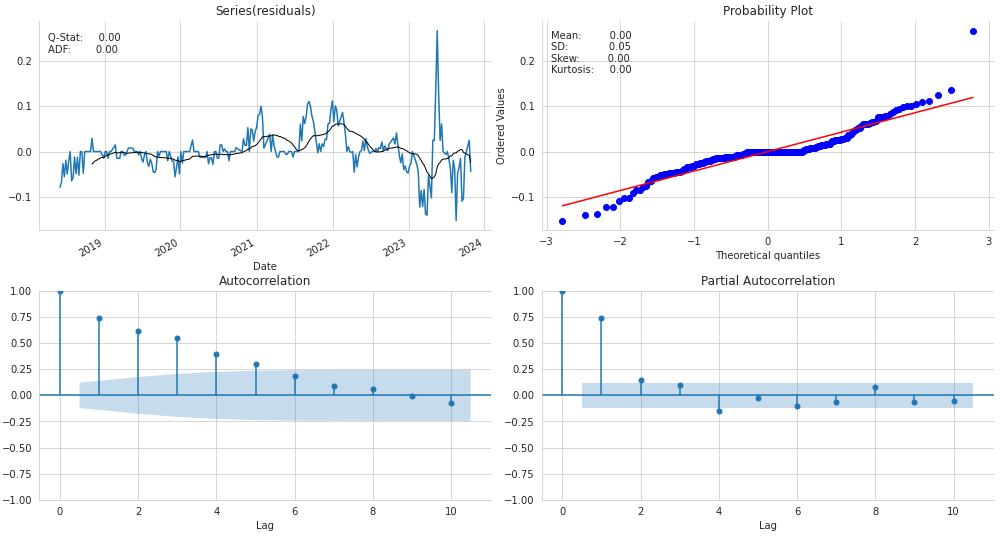

In [6]:
plot_correlogram(ro)

## AR(p = 1) 

In [10]:
# ro_stationary 

AR_1_result = tsa.ARIMA(ro,order=(1,0,0)).fit()
a, b, std = AR_1_result.params
theta = b 
mu = a/(1-b)
et = AR_1_result.resid/(1-b)
fitted = mu + et

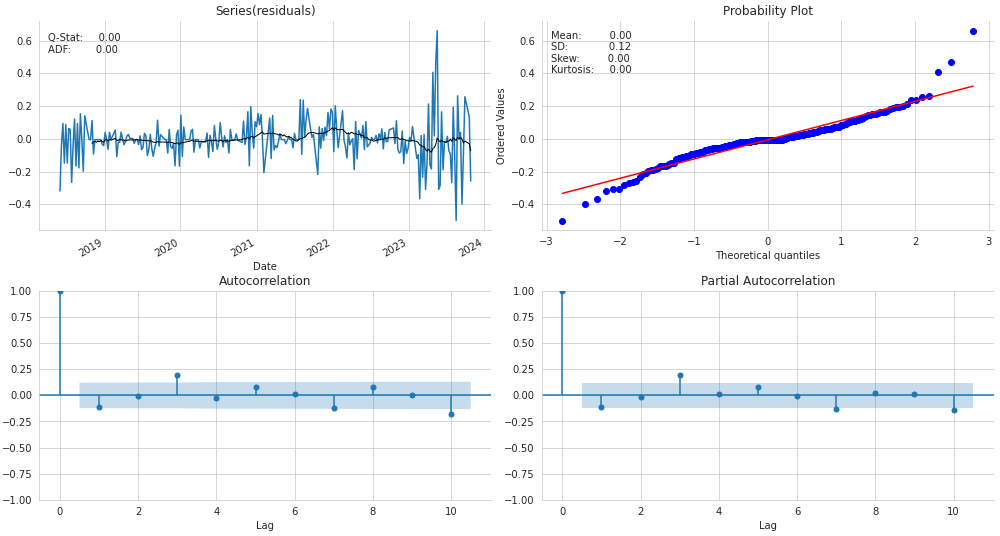

In [8]:
plot_correlogram(fitted)

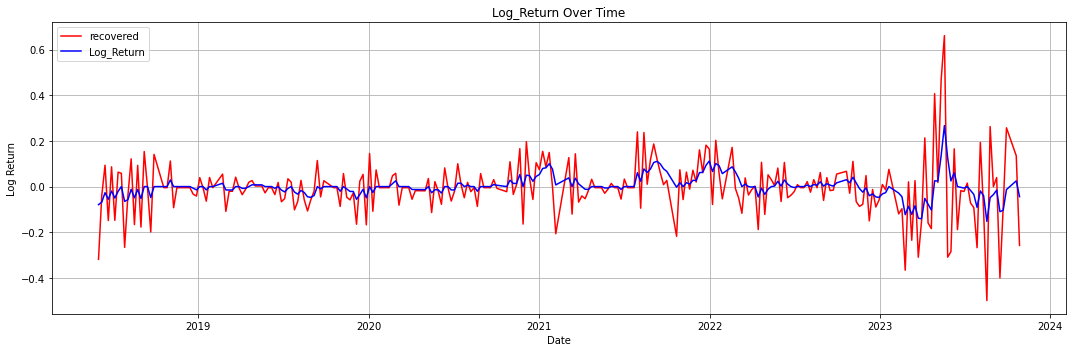

In [11]:
# plot fitted and original one: 

# Separate plot for 'Log_Return' for clarity and because it might be on a different scale
plt.figure(figsize=(15, 5))
plt.plot(ro.index, fitted, label="recovered", color="red")
plt.plot(ro.index, ro, label="Log_Return", color="blue")
plt.title("Log_Return Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression 

In [12]:
import pandas as pd
upstream_companies = pd.read_csv("../data/Upstream_companies.csv")

In [16]:
def individual_company_concur(target_df, ticker, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, upstream_companies = upstream_companies, sampling_period = 'W-FRI')
    
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Li_LogReturn', "Asset", "Assest_LogReturn"]
    
    model = smf.ols('Li_LogReturn~ Assest_LogReturn', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'coefficient' : model.params['Assest_LogReturn'],
    'coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'hac_standard_error' : model.bse['Assest_LogReturn']}
    
    return res

In [17]:
import pandas as pd
target_df = pd.DataFrame(fitted)
start_date = '2018-05-26'
end_date = '2023-08-07'
result1 = []

for ticker in upstream_companies.Stock:
    try:
        res = individual_company_concur(target_df, ticker, start_date, end_date)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result1.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1315, 8)
AUDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1306, 8)
USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1311, 8)
GBpCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complet

In [18]:
res = individual_company_concur(target_df, ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1304, 8)
CADCNY=X
[*********************100%***********************]  1 of 1 completed


In [21]:
df_result1 = pd.DataFrame(result1)
df_result1.set_index('ticker', inplace=True)
df_result1.to_csv(f"result/li2co3_task2_1.csv")

In [22]:
df_result1[df_result1.coefficient_pvalue<=0.05].sort_values("coefficient_pvalue")

,intercept,intercept_pvalue,coefficient,coefficient_pvalue,hac_standard_error
ticker,,,,,
SYA.AX,-0.002647,0.707030,0.115790,0.003199,0.039278
LTHM,-0.000303,0.967750,0.147392,0.016210,0.061307
002497.SZ,-0.002022,0.778035,0.169533,0.029479,0.077874
ALB,-0.002406,0.731318,0.235349,0.037321,0.113027
SQM,-0.002069,0.769353,0.195268,0.046407,0.098042
002466.SZ,-0.002367,0.740115,0.157703,0.047885,0.079713


In [23]:
# Calculate moving averages for various lags
def individual_company_lag(target_df, ticker, lag, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date , upstream_companies = upstream_companies, sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'lag_coefficient' : model.params['Asset_Lag'],
    'lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'hac_standard_error' : model.bse['Asset_Lag']}
    
    return res


In [24]:
result = []

for ticker in upstream_companies.Stock:
    for lag in range(1,5):
        try:
            res = individual_company_lag(target_df, ticker, lag = lag, start_date = start_date, end_date= end_date)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)


In [25]:
df_result2 = pd.DataFrame(result)
df_result2 = df_result2.set_index(['ticker', 'lag'])
df_result2.to_csv(f"result/li2co3_task2_2.csv")

In [26]:
df_result2.loc[df_result2.lag_coefficient_pvalue <= 0.05]

intercept  intercept_pvalue  lag_coefficient  \
ticker    lag                                                 
002466.SZ 2    -0.002764          0.700647         0.201205   
AKE.AX    1    -0.002699          0.694642         0.259675   
          2    -0.003198          0.642834         0.269335   
          3    -0.002523          0.717328         0.240235   
          4    -0.003503          0.608543         0.366837   
LEL.AX    1     0.006248          0.665780         0.325577   
LIS.V     1    -0.000851          0.906259         0.095455   
LPI.AX    1    -0.001411          0.843219         0.196935   
LTH.V     1     0.001649          0.911026         0.138306   
LTHM      3    -0.000926          0.902080         0.231702   
PLS.AX    1    -0.003428          0.613872         0.275117   
          2    -0.003744          0.580060         0.263190   
          3    -0.003301          0.624220         0.280777   
          4    -0.004438          0.503416         0.393782   

               lag_coefficient_pvalue  hac_standard_error  
ticker    lag                                              
002466.SZ 2                  0.035887            0.095894  
AKE.AX    1                  0.010436            0.101395  
          2                  0.026665            0.121520  
          3                  0.035455            0.114228  
          4                  0.009732            0.141898  
LEL.AX    1                  0.036032            0.155290  
LIS.V     1                  0.012272            0.038118  
LPI.AX    1                  0.018598            0.083678  
LTH.V     1                  0.043640            0.068552  
LTHM      3                  0.043244            0.114628  
PLS.AX    1                  0.000196            0.073866  
          2                  0.002867            0.088269  
          3                  0.002814            0.093989  
          4                  0.000891            0.118511

In [36]:
def individual_company_concur_lag1(target_df, ticker, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, upstream_companies = upstream_companies, sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Li_LogReturn', "Asset", "Assest_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    model = smf.ols('Li_LogReturn~ Assest_LogReturn + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_coefficient' : model.params['Assest_LogReturn'],
    'asset_coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'asset_hac_standard_error' : model.bse['Assest_LogReturn'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [37]:
result3_1 = []

for ticker in upstream_companies.Stock:
    try:
        res = individual_company_concur_lag1(target_df, ticker,  start_date = start_date, end_date= end_date)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result3_1.append(res)
    
df_result3_1 = pd.DataFrame(result3_1)
df_result3_1 = df_result3_1.set_index('ticker')
df_result3_1.to_csv(f"result/li2co3_task2_3(1).csv")

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1315, 8)
AUDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1306, 8)
USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1311, 8)
GBpCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complet

In [39]:
df_result3_1.loc[(df_result3_1.asset_coefficient_pvalue <= 0.05)][['asset_coefficient',
       'asset_coefficient_pvalue', 'asset_hac_standard_error',
       'lithium_lag1_coefficient', 'lithium_lag1_coefficient_pvalue',
       'lithium_lag1_hac_standard_error']]

,asset_coefficient,asset_coefficient_pvalue,asset_hac_standard_error,lithium_lag1_coefficient,lithium_lag1_coefficient_pvalue,lithium_lag1_hac_standard_error
ticker,,,,,,
002466.SZ,0.167616,0.027761,0.076167,-0.116967,0.256409,0.103062
002497.SZ,0.176578,0.018280,0.074825,-0.113342,0.270457,0.102850
ALB,0.239026,0.031342,0.111036,-0.111543,0.277203,0.102651
LTHM,0.144720,0.020649,0.062532,-0.055718,0.591463,0.103813
SQM,0.196601,0.040423,0.095931,-0.109599,0.295493,0.104765
SYA.AX,0.117750,0.001169,0.036272,-0.113081,0.267188,0.101915


In [40]:
def individual_company_lag_lag1(target_df, ticker, lag, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, upstream_companies = upstream_companies, sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_lag_coefficient' : model.params['Asset_Lag'],
    'asset_lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'asset_lag_hac_standard_error' : model.bse['Asset_Lag'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [41]:
result3_2 = []

for ticker in upstream_companies.Stock:
    for lag in range(1,5):
        try:
            res = individual_company_lag_lag1(target_df, ticker, lag = lag, start_date = start_date, end_date= end_date)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result3_2.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1261, 8)


In [43]:
df_result3_2 = pd.DataFrame(result3_2)
df_result3_2 = df_result3_2.set_index(["ticker", "lag"])

In [44]:
df_result3_2.to_csv(f"result/li2co3_task2_3(2).csv")
df_result3_2.head()

intercept  intercept_pvalue  asset_lag_coefficient  \
ticker    lag                                                       
002176.SZ 1    -0.002182          0.784280               0.148708   
          2    -0.002531          0.754232               0.137244   
          3    -0.001985          0.807132               0.139299   
          4    -0.002517          0.755033               0.251312   
002460.SZ 1    -0.002466          0.761446               0.152341   

               asset_lag_coefficient_pvalue  asset_lag_hac_standard_error  \
ticker    lag                                                               
002176.SZ 1                        0.105510                      0.091868   
          2                        0.293869                      0.130749   
          3                        0.436349                      0.178961   
          4                        0.206387                      0.198891   
002460.SZ 1                        0.108200                      0.094837   

               lithium_lag1_coefficient  lithium_lag1_coefficient_pvalue  \
ticker    lag                                                              
002176.SZ 1                   -0.112304                         0.277766   
          2                   -0.115051                         0.284442   
          3                   -0.108225                         0.312173   
          4                   -0.106578                         0.324563   
002460.SZ 1                   -0.112874                         0.269418   

               lithium_lag1_hac_standard_error  
ticker    lag                                   
002176.SZ 1                           0.103472  
          2                           0.107485  
          3                           0.107082  
          4                           0.108187  
002460.SZ 1                           0.102204

In [45]:
df_result3_2.loc[(df_result3_2.asset_lag_coefficient_pvalue <= 0.05)][['asset_lag_coefficient',
       'asset_lag_coefficient_pvalue', 'asset_lag_hac_standard_error',
       'lithium_lag1_coefficient', 'lithium_lag1_coefficient_pvalue',
       'lithium_lag1_hac_standard_error']]

asset_lag_coefficient  asset_lag_coefficient_pvalue  \
ticker    lag                                                        
002466.SZ 2                 0.231069                      0.031430   
AKE.AX    1                 0.278847                      0.005336   
          2                 0.328787                      0.005983   
          3                 0.293319                      0.010442   
          4                 0.415885                      0.002804   
ALB       2                 0.285517                      0.045917   
CRE.V     1                 0.122770                      0.046612   
LEL.AX    1                 0.331285                      0.031193   
          3                 0.364259                      0.042121   
LIS.V     1                 0.096076                      0.011959   
LPI.AX    1                 0.201209                      0.015889   
LTH.V     1                 0.138303                      0.043686   
LTHM      1                 0.129954                      0.049516   
          2                 0.239166                      0.028296   
          3                 0.264143                      0.019859   
PLS.AX    1                 0.291118                      0.000063   
          2                 0.315874                      0.000460   
          3                 0.328589                      0.000671   
          4                 0.444837                      0.000169   
SYA.AX    1                 0.070527                      0.044172   

               asset_lag_hac_standard_error  lithium_lag1_coefficient  \
ticker    lag                                                           
002466.SZ 2                        0.107395                 -0.123996   
AKE.AX    1                        0.100087                 -0.131352   
          2                        0.119616                 -0.145206   
          3                        0.114540                 -0.126864   
          4                        0.139163                 -0.123529   
ALB       2                        0.143033                 -0.125054   
CRE.V     1                        0.061699                 -0.112704   
LEL.AX    1                        0.153757                 -0.039627   
          3                        0.179233                 -0.051102   
LIS.V     1                        0.038226                 -0.109514   
LPI.AX    1                        0.083439                 -0.115860   
LTH.V     1                        0.068566                 -0.000904   
LTHM      1                        0.066164                 -0.075772   
          2                        0.109051                 -0.085816   
          3                        0.113414                 -0.084183   
PLS.AX    1                        0.072777                 -0.132845   
          2                        0.090170                 -0.150563   
          3                        0.096611                 -0.135439   
          4                        0.118242                 -0.135380   
SYA.AX    1                        0.035046                 -0.123556   

               lithium_lag1_coefficient_pvalue  \
ticker    lag                                    
002466.SZ 2                           0.243760   
AKE.AX    1                           0.147031   
          2                           0.127130   
          3                           0.192846   
          4                           0.203534   
ALB       2                           0.232433   
CRE.V     1                           0.271619   
LEL.AX    1                           0.664332   
          3                           0.599810   
LIS.V     1                           0.276324   
LPI.AX    1                           0.229425   
LTH.V     1                           0.993243   
LTHM      1                           0.446866   
          2                           0.389036   
          3                           0.400695   
PLS.AX    1      